In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import snn_classifier as snn_clas

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [ ]:
audio_dir = '../ESC-50/audio/'

In [3]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['animal', 'nature', 'human', 'domestic', 'urban']

In [5]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    if target < 10:
        dataset.loc[index, 'h_category'] = 0
    elif target < 20:
        dataset.loc[index, 'h_category'] = 1
    elif target < 30:
        dataset.loc[index, 'h_category'] = 2
    elif target < 40:
        dataset.loc[index, 'h_category'] = 3
    elif target < 50:
        dataset.loc[index, 'h_category'] = 4

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [ ]:
def load_all_audio(fld, data):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    f_df['y'] = None
    for i, sample in f_df.iterrows():
        y, sr = librosa.load(audio_dir + sample['filename'], sr=44100, mono=True)
        f_df.at[i, 'y'] = (1,y)
    print("\tProcessing Time: " + str(time.time() - start_time))
    return f_df[['target', 'h_category', 'y']]

In [7]:
c_data = load_all_audio(1, dataset)

In [8]:
c_data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0


In [10]:
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target'])
train_y = train.target
test_X = test.drop(columns=['target'])
test_y = test.target

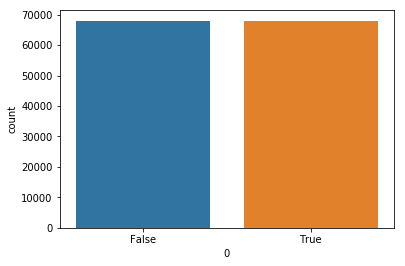

In [11]:
import seaborn as sns
xx, yy = du.balanced_subsample(train_X, train_y.between(0,10))
sns.countplot(yy[0])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Dense(38, activation='relu', input_shape=(38,)))
    model.add(Dropout(0.2))
    model.add(Dense(5, kernel_initializer='normal', activation='softmax'))
    
    model.summary()
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_1 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 39        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
122314/122314 [==============================] - 14s 114us/step - loss: 0.6082
Epoch 2/20
122314/122314 [==============================] - 5s 40us/step - loss: 0.5543
Epoch 3/20
122314/122314 [==============================] - 5s 43us/step - loss: 0.5365
Epoch 4/20
122314/122314 [==============================] - 5s 44us/step - loss: 0.5263
Epoch 5/20
122314/122314 [========================

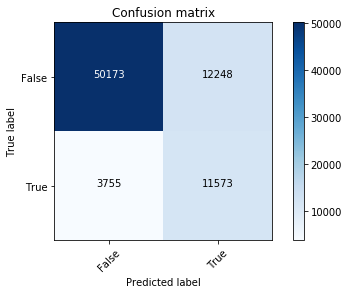

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_2 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 39        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
133424/133424 [==============================] - 6s 47us/step - loss: 0.6254
Epoch 2/20
133424/133424 [==============================] - 5s 39us/step - loss: 0.5836
Epoch 3/20
133424/133424 [==============================] - 5s 39us/step - loss: 0.5697
Epoch 4/20
133424/133424 [==============================] - 5s 38us/step - loss: 0.5625
Epoch 5/20
133424/133424 [==========================

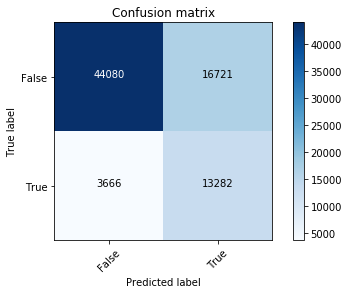

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_3 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 39        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
117372/117372 [==============================] - 5s 46us/step - loss: 0.6461
Epoch 2/20
117372/117372 [==============================] - 5s 39us/step - loss: 0.6062
Epoch 3/20
117372/117372 [==============================] - 5s 39us/step - loss: 0.5890
Epoch 4/20
117372/117372 [==============================] - 4s 38us/step - loss: 0.5800
Epoch 5/20
117372/117372 [==========================

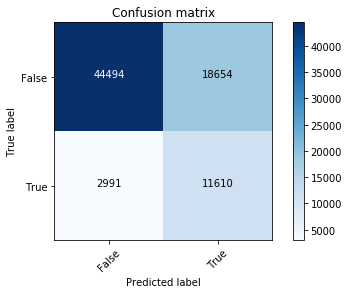

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_4 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 39        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
115644/115644 [==============================] - 7s 61us/step - loss: 0.6183
Epoch 2/20
115644/115644 [==============================] - 5s 41us/step - loss: 0.5860
Epoch 3/20
115644/115644 [==============================] - 5s 40us/step - loss: 0.5755
Epoch 4/20
115644/115644 [==============================] - 5s 39us/step - loss: 0.5689
Epoch 5/20
115644/115644 [==========================

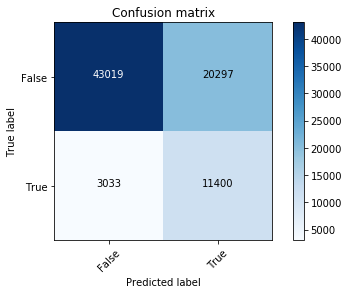

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_5 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 39        
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
133234/133234 [==============================] - 6s 45us/step - loss: 0.5655
Epoch 2/20
133234/133234 [==============================] - 5s 38us/step - loss: 0.5113
Epoch 3/20
133234/133234 [==============================] - 5s 38us/step - loss: 0.4968
Epoch 4/20
133234/133234 [==============================] - 5s 38us/step - loss: 0.4901
Epoch 5/20
133234/133234 [==========================

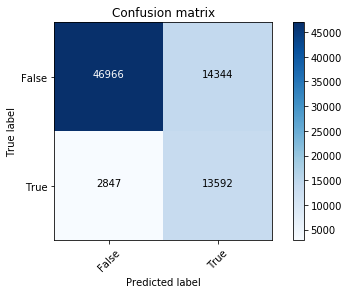

In [12]:
hl_shallow = {}
for i in range(0,5):
    start_i = i * 10
    end_i = ((i + 1) * 10) - 1
#     Get equally distributed set of positive and negative instances
    xx, yy = du.balanced_subsample(train_X, train_y.between(start_i, end_i))
    clas = KerasClassifier(build_fn=snn_clas.create_baseline, epochs=20, batch_size=128, verbose=1)
    clas.fit(xx, yy)
    pred = clas.predict(test_X)
    pred = [item[0] for item in pred]
    print(str(h_classes[i]) + ": " + 
      str(metrics.accuracy_score(test_y.between(start_i, end_i), pred)))
    cm = metrics.confusion_matrix(test_y.between(start_i, end_i), pred)
    plot_confusion_matrix(cm, ['False', 'True'])
    plt.show()
    hl_shallow[h_classes[i]] = clas